# Quickstart

Short script to show how to fit a simple 1D `sin(x)` function using `jenn`. 

In [1]:
import numpy as np 
import jenn 

# Function to be learned 
f = lambda x: np.sin(x)  
f_prime = lambda x: np.cos(x).reshape((1, 1, -1))  # note: jacobian adds a dimension

# Sampling plan (number of examples)
m_train = 4 
m_test = 30

# Generate training data 
x_train = np.linspace(-np.pi , np.pi, m_train).reshape((1, -1))
y_train = f(x_train)
dydx_train = f_prime(x_train)

# Generate test data 
x_test = np.linspace(-np.pi , np.pi, m_test).reshape((1, -1))
y_test = f(x_test)
dydx_test = f_prime(x_test)

# Fit model
nn = jenn.model.NeuralNet(
    layer_sizes=[x_train.shape[0], 3, 3, y_train.shape[0]],  # note: user defines hidden layer architecture
    ).fit(
        x_train, y_train, dydx_train, is_normalize=True  # see docstr for full list of hyperparameters
    )

# Predict response only 
y_pred = nn.predict(x_test)

# Predict partials only 
dydx_pred = nn.predict_partials(x_train)

# Predict response and partials in one step 
y_pred, dydx_pred = nn.evaluate(x_test) 

# Check how well modell generalizes 
assert jenn.utils.metrics.r_square(y_pred, y_test) > 0.99
assert jenn.utils.metrics.r_square(dydx_pred, dydx_test) > 0.99

# Save model for later re-use
nn.save('parameters.json')

Reload saved model:

In [2]:
new_model = jenn.model.NeuralNet(layer_sizes=[1, 12, 1]).load('parameters.json')

y_reloaded, dydx_reloaded = new_model.evaluate(x_test) 

assert np.allclose(y_reloaded, y_pred)
assert np.allclose(dydx_reloaded, dydx_pred)

### Optional Visualization Tools

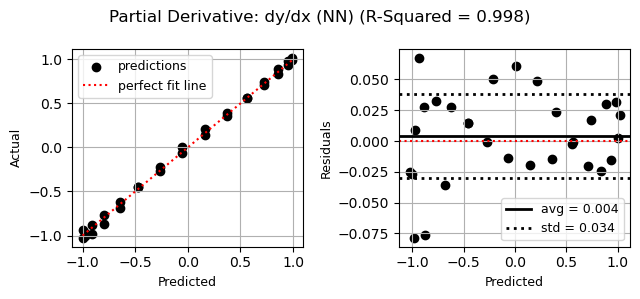

In [3]:
# Example: show goodness of fit of the partials 
jenn.utils.plot.goodness_of_fit(
    y_true=dydx_test[0], 
    y_pred=nn.predict_partials(x_test)[0], 
    title="Partial Derivative: dy/dx (NN)"
)

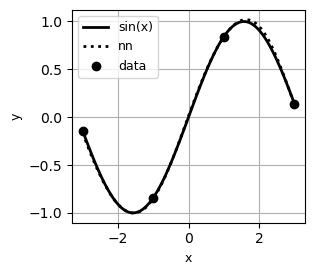

In [4]:
# Example: visualize local sensitivities
jenn.utils.plot.sensitivity_profiles(
    f=[f, nn.predict], 
    x_min=x_train.min(), 
    x_max=x_train.max(), 
    x_true=x_train, 
    y_true=y_train, 
    resolution=100, 
    legend=['sin(x)', 'nn'], 
    xlabels=['x'], 
    ylabels=['y'],
    show_cursor=False
)